A first attempt at the kaggle dstl satellite competition, getting familiar witn satellite image procesing etc. The aim of the competition is to classify different objects on the ground from satellite images.

#### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj

env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [52]:
from datetime import datetime
from tqdm import tqdm
from skimage.external import tifffile as sktif

import shapely.wkt
import geopandas as gpd
import numpy as np
import cv2
from joblib import Parallel, delayed
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"
from importlib import reload

#### The data
Two sets of image data are provided: 3 band (rgb) and the full 16 band data. Since both are quite big,  I'll just work with the 3band (rgb) data to start with as that is more intutive. Also, the object masks are scaled to 0-1 by the competiton so we have to transform the polygons back into the right shape to match with the images

The 10 classes are:

1. Buildings - large building, residential, non-residential, fuel storage facility, fortified building
2. Misc. Manmade structures 
3. Road 
4. Track - poor/dirt/cart track, footpath/trail
5. Trees - woodland, hedgerows, groups of trees, standalone trees
6. Crops - contour ploughing/cropland, grain (wheat) crops, row (potatoes, turnips) crops
7. Waterway 
8. Standing water
9. Vehicle Large - large vehicle (e.g. lorry, truck,bus), logistics vehicle
10. Vehicle Small - small vehicle (car, van), motorbike

In [3]:
data_dir = Path("/media/wwymak/Storage/kaggle-dstl")
data_dir.ls()

[PosixPath('/media/wwymak/Storage/kaggle-dstl/building_masks_train'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/dummy_img_dir'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/train_wkt_v4.csv'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/train_geojson_v3'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/sample_submission.csv'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/grid_sizes.csv.zip'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/sample_submission.csv.zip')]

In [4]:
IMG_HEIGHT = 3349
IMG_WIDTH = 3391

The grid sizes are used to map the polygons back into the correct pixels for the image masks.

In [5]:
grid_sizes = pd.read_csv(data_dir / "grid_sizes.csv.zip", 
                         header=None,
                         skiprows=1,
                         names = ["img_id", "xmax", "ymin"], )
grid_sizes.set_index("img_id", inplace=True)
grid_sizes.head()

,xmax,ymin
img_id,,
6120_2_4,0.009180,-0.00904
6120_2_3,0.009169,-0.00904
6120_2_2,0.009188,-0.00904
6120_2_1,0.009188,-0.00904
6120_2_0,0.009188,-0.00904


These are the filepaths for a few of the images-- we can see that the x.tif matches with the ids in the label/grid_sizes keys. According to the organisers, the 3band images are all 3349 (height), 3391 (Width)

In [9]:
(data_dir /"three_band").ls()[:5]

[PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6030_1_3.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6030_3_3.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6040_2_1.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6090_1_3.tif'),
 PosixPath('/media/wwymak/Storage/kaggle-dstl/three_band/6090_4_1.tif')]

We can see that there aren't actually that many training images. However, each image is huge and contains multiple classes of things. It might make life a lot easier if we chop up each image into smaller pieces, do a separate classification/segmentation on them and combine the final result... But let's process the labels/transofrmas and look at the data first

In [6]:
labels = pd.read_csv(data_dir / "train_wkt_v4.csv")
print(labels.ImageId.nunique())
labels.set_index("ImageId", inplace=True)
labels.shape

25


(250, 2)

In [11]:
test = pd.read_csv(data_dir / "sample_submission.csv")
test.ImageId.nunique()

429

#### Polygon rescaling

In [7]:
labels.MultipolygonWKT= labels.MultipolygonWKT.apply(lambda x: shapely.wkt.loads(x))

In [8]:
labels = labels.merge(grid_sizes, left_index=True, right_index=True, how="left")
labels.head()

,ClassType,MultipolygonWKT,xmax,ymin
6010_1_2,1,(),0.009169,-0.009042
6010_1_2,2,(POLYGON ((0.008926999999999999 -0.00857499999...,0.009169,-0.009042
6010_1_2,3,(),0.009169,-0.009042
6010_1_2,4,"(POLYGON ((0.008765 -0.007289, 0.00885 -0.0072...",0.009169,-0.009042
6010_1_2,5,"(POLYGON ((0.007405 -0.009022000000000001, 0.0...",0.009169,-0.009042


In [10]:
labels["imgid"] = labels.index
img_sizes = labels["imgid"].apply(lambda fname: 
    sktif.imread(str(data_dir / "three_band"/ f"{fname}.tif")).transpose([1, 2, 0]).shape[:2])
labels["imgy"] = [x[0] for x in img_sizes]
labels["imgx"] = [x[1] for x in img_sizes]

In [11]:
labels["imgx"].unique()

array([3396, 3393, 3391, 3387, 3403, 3338, 3389])

In [13]:
def scaler(h, w, xmax, ymin):
    w_ = w * w /( w+1)
    h_ = h * h/(h+1)
    x_scale = w_ / xmax
    y_scale = h_ / ymin
    return x_scale, y_scale

In [15]:

def scale_polygon(row):
    fname = row['imgid']
    polygon = row.MultipolygonWKT
    if not polygon:
        return
    img_height = row["imgy"]
    img_width = row["imgx"]
    
    xscale, yscale = scaler(img_height, img_width, row["xmax"], row["ymin"])
    return shapely.affinity.scale(polygon, xfact=xscale, yfact=yscale, origin=(0,0,0))
labels["scale_poly"] = labels.apply(lambda row: scale_polygon(row), axis=1)

In [16]:
labels.head()

,ClassType,MultipolygonWKT,xmax,ymin,imgid,imgy,imgx,scale_poly
6010_1_2,1,(),0.009169,-0.009042,6010_1_2,3349,3396,None
6010_1_2,2,(POLYGON ((0.008926999999999999 -0.00857499999...,0.009169,-0.009042,6010_1_2,3349,3396,(POLYGON ((3305.395095201982 3175.083229341019...
6010_1_2,3,(),0.009169,-0.009042,6010_1_2,3349,3396,None
6010_1_2,4,"(POLYGON ((0.008765 -0.007289, 0.00885 -0.0072...",0.009169,-0.009042,6010_1_2,3349,3396,"(POLYGON ((3245.41144947299 2698.913312964045,..."
6010_1_2,5,"(POLYGON ((0.007405 -0.009022000000000001, 0.0...",0.009169,-0.009042,6010_1_2,3349,3396,"(POLYGON ((2741.845040883912 3340.59485657314,..."


#### Class distribution

Expects certain classes to take up a lot less pixels than others (e.g. more pixels for buildings than roads)

In [21]:
labels["area"] = labels["scale_poly"].apply(lambda x: x.area if x else None)

In [25]:
labels["percent_area"] = labels["area"] / (labels["imgy"] * labels["imgx"])
labels[["ClassType", "percent_area"]].groupby("ClassType").mean().sort_values(by= "percent_area", ascending=False)

,percent_area
ClassType,
6,0.491207
5,0.101726
1,0.068767
7,0.062574
4,0.032597
3,0.018366
2,0.010363
8,0.003236
10,0.000293


We can see that there are some very frequent categories eg. crops/trees whereas some classes are very sparse e.g. vehicles. 

### Data Inspection

slightly arbitrarily, we start with buildings. The easiest solution (for now) is probably just to have 1 net per class, given how spread out the class distributions are

In [26]:
imgid = "6120_2_2"
class_type = 1
img_rgb = sktif.imread(str(data_dir / "three_band"/ f"{imgid}.tif")).transpose([1, 2, 0])
mask_polygons = labels.loc[(labels.index == imgid) & \
                           (labels.ClassType == 1) ]["scale_poly"][0]

In [27]:
def create_mask(polygons, h,w):
    img_mask = np.zeros((h,w), dtype=np.uint8)
    if polygons:
        exterior = [np.array(poly.exterior.coords).round().astype(np.int32) for poly in polygons] # the boundary of polygon
        interior = [np.array(pi.coords).round().astype(np.int32) for poly in polygons for pi in poly.interiors]#fill in internal holes
        
        cv2.fillPoly(img_mask, exterior,1)
        cv2.fillPoly(img_mask, interior,0)
    return img_mask

In [28]:
def scale_percentile(matrix):
    """
    for scaling the tif files, which have numeric ranges > 256 backk to 256 for display
    """
    w, h, d = matrix.shape
    matrix = np.reshape(matrix, [w * h, d]).astype(np.float64)
    # Get 2nd and 98th percentile
    mins = np.percentile(matrix, 1, axis=0)
    maxs = np.percentile(matrix, 99, axis=0) - mins
    matrix = (matrix - mins[None, :]) / maxs[None, :]
    matrix = np.reshape(matrix, [w, h, d])
    matrix = matrix.clip(0, 1)
    return matrix

In [29]:
img_mask = create_mask(mask_polygons, IMG_HEIGHT, IMG_WIDTH)

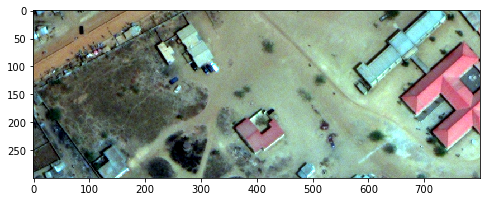

In [30]:
fig = plt.figure(figsize=(8,6))
sktif.imshow(255 * scale_percentile(img_rgb[2900:3200,1500:2300]),figure=fig);

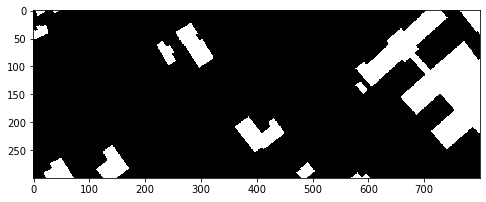

In [31]:
def show_mask(m, **kwargs):
    # hack for nice display
    sktif.imshow(255 * np.stack([m, m, m]),  **kwargs);
fig = plt.figure(figsize=(8,6))
show_mask(img_mask[2900:3200,1500:2300],figure=fig)

### Segmentation nets

#### Simple step 1:
- Unet segmentation of patches of size 256 by 256. 
- patches are created with the sliding window of step 128 (ie there's overlaps)

##### First, create all the masks for buildings in the training set:

In [46]:
(data_dir / "masks_train").mkdir(exist_ok=True)
(data_dir /"img_tiles_train").mkdir(exist_ok=True)
masks_train_dir = data_dir / "masks_train"
img_tiles_train_dir = data_dir /"img_tiles_train"

In [33]:
building_labels = labels.loc[(labels.ClassType == 1) & (labels.scale_poly.notnull())]
train_imgs = [data_dir / "three_band"/ f"{imgid}.tif" for imgid in building_labels.imgid]

In [34]:
building_labels.head()

,ClassType,MultipolygonWKT,xmax,ymin,imgid,imgy,imgx,scale_poly,area,percent_area
6060_2_3,1,"(POLYGON ((0.006565 -0.008494, 0.006652 -0.008...",0.009188,-0.009040,6060_2_3,3348,3403,(POLYGON ((2430.793636113778 3144.847404455695...,15825.278287,0.001389
6070_2_3,1,(POLYGON ((0.0045699999999998 -0.0090449999999...,0.009013,-0.009045,6070_2_3,3350,3338,(POLYGON ((1692.085676571975 3349.000298418345...,173594.274774,0.015524
6100_1_3,1,"(POLYGON ((0.000748 -0.009042, 0.000745 -0.009...",0.009156,-0.009042,6100_1_3,3349,3391,(POLYGON ((276.9462888290593 3348.000298507463...,995571.759154,0.087666
6100_2_2,1,"(POLYGON ((0.007676 -0.005554, 0.007721 -0.005...",0.009156,-0.009042,6100_2_2,3349,3391,(POLYGON ((2842.031701940989 2056.491225161518...,361143.681458,0.031801
6100_2_3,1,(POLYGON ((0.008963998153499299 -0.00904199813...,0.009156,-0.009042,6100_2_3,3349,3391,(POLYGON ((3319.020542727564 3347.888530929807...,933320.402651,0.082184


In [35]:
building_masks = building_labels.apply(lambda row:
    create_mask(row["scale_poly"], row["imgy"], row["imgx"]), axis=1)

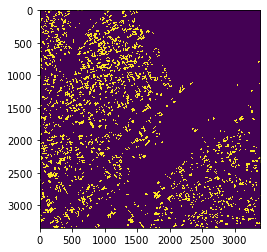

In [44]:
plt.imshow(building_masks[2])

In [99]:
slice_indexes = list(range(0,min(building_labels.imgx.max(), building_labels.imgy.max())-128, 128))
def parse_one_image_array(img_array, img_id, save_dir, save_filename_format="{}_{}_{}.tif"):
    for i in slice_indexes:
        for j in slice_indexes:
            img_slice = img_array[i:i+256, j:j+256, ...]
            if img_slice.size == 0:
                print(i, j,'empty', img_slice.shape)
            sktif.imsave(str(save_dir/ save_filename_format.format(img_id,i, j)), img_slice)
            
def parse_one_mask_array(mask_array, img_id, class_label, save_dir, save_filename_format="{}_{}_{}_{}.tif"):
    for i in slice_indexes:
        for j in slice_indexes:
            img_slice = mask_array[i:i+256, j:j+256] 
            sktif.imsave(str(save_dir/ save_filename_format.format(img_id,class_label, i, j)), img_slice)

In [100]:

def save_mask_imgs_patches(img_id, **kwargs):

    img_rgb = sktif.imread(str(data_dir / "three_band"/ f"{img_id}.tif")).transpose([1, 2, 0])
    img_rgb_scaled = 255* scale_percentile(img_rgb)
    img_masks_rows =  labels.loc[(labels.index == img_id)]
    img_masks_arrays = img_masks_rows.apply(lambda row:
        create_mask(row["scale_poly"], row["imgy"], row["imgx"]), axis=1)
    
    parse_one_image_array(img_rgb_scaled, img_id, save_dir=img_tiles_train_dir)
    for class_label, mask_arr in zip(img_masks_rows.ClassType, img_masks_arrays):
        parse_one_mask_array(mask_arr, img_id, class_label, masks_train_dir)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [97]:
img_id = "6040_4_4"
img_rgb = sktif.imread(str(random_10_imgs[1]))#.transpose([1, 2, 0])
img_rgb_scaled = 255* scale_percentile(img_rgb)
img_rgb.min(), img_rgb.max(), img_rgb_scaled.min(), img_rgb_scaled.max()

(270, 576, 0.0, 255.0)

In [98]:
img_rgb.shape

(3346, 3387, 3)

(<Figure size 988.8x604.8 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x7efda56c5940>)

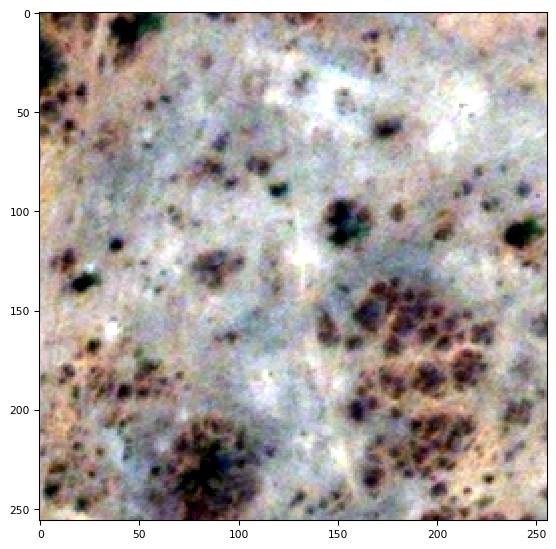

In [96]:
sktif.imshow(img_rgb_scaled)

In [53]:
start = datetime.now()
[save_mask_imgs_patches(img_id) for img_id in labels.index.unique()]
end = datetime.now()
print(end-start)

0:04:29.936376


##### img/mask inspection

As expected, the masks have 10 times the tiles in the imgs (10 classes per img)

In [54]:
len(masks_train_dir.ls()), len(img_tiles_train_dir.ls())

(169000, 16900)

In [71]:
random_10_imgs = np.random.choice(img_tiles_train_dir.ls(), 10)
building_mask_names = [f'{"_".join(img_path.name.split("_")[:3])}_1_{"_".join(img_path.name.split("_")[3:])}' for img_path in random_10_imgs]

random_10_imgs_building_masks = [masks_train_dir / name for name in building_mask_names]

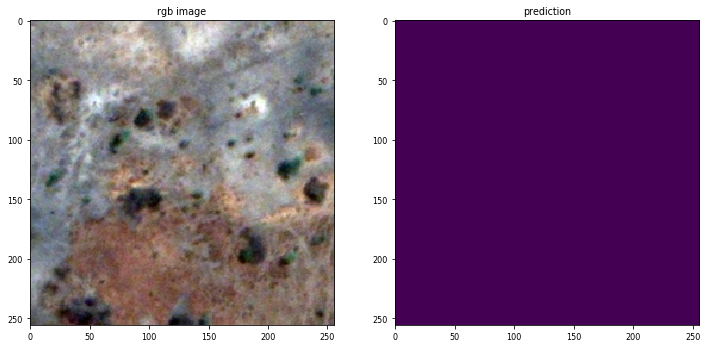

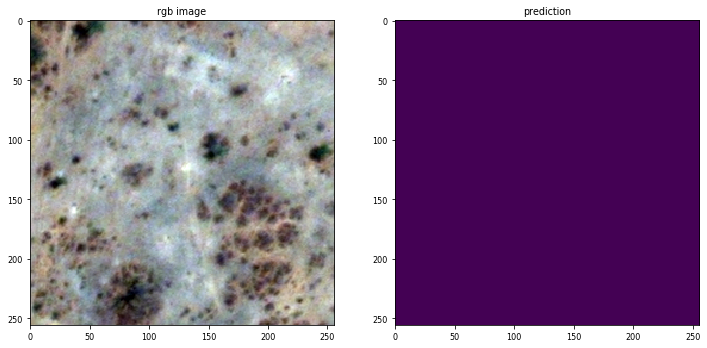

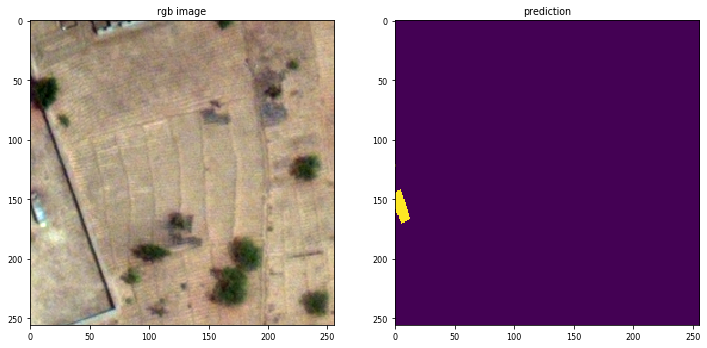

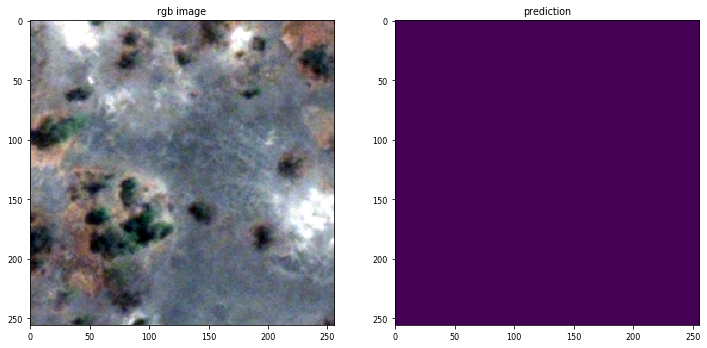

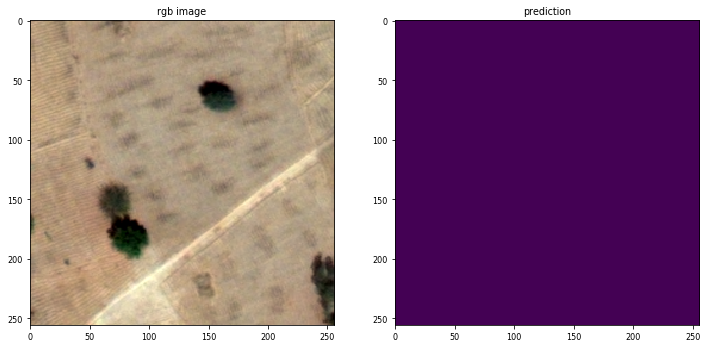

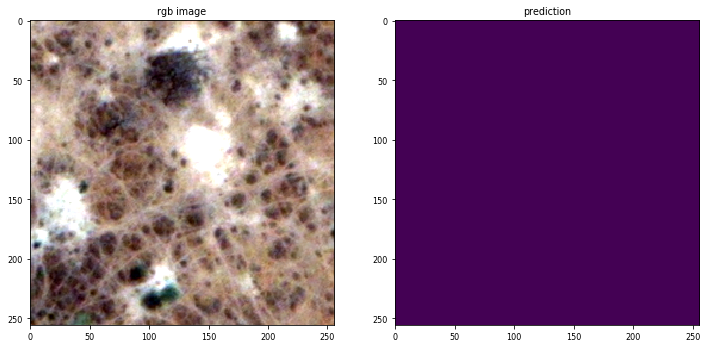

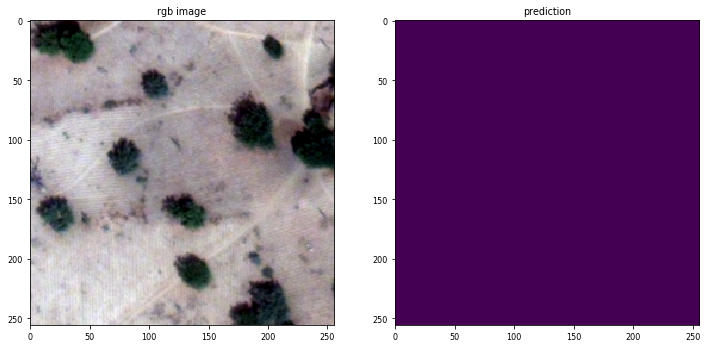

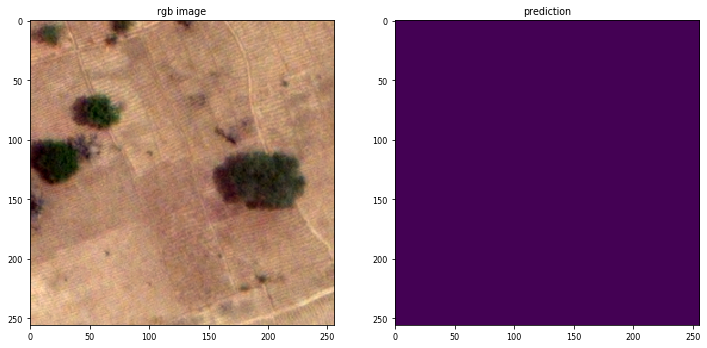

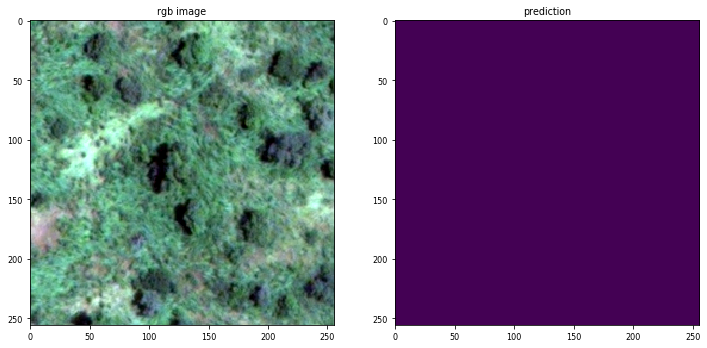

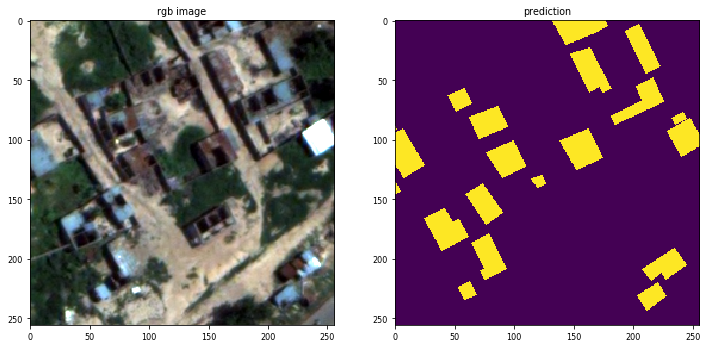

In [107]:
def plot_one_img(img_path, mask_path):
    fig, axes = plt.subplots(ncols=2,nrows=1, figsize=(12,8))
    ax = axes.ravel()

    img_rgb = sktif.imread(str(img_path))
#     print(img_rgb_scaled.shape, img_rgb_scaled.max())
    sktif.imshow(img_rgb, subplot=ax[0], figure=fig)
    ax[0].set_title('rgb image')
    ax[1].imshow(sktif.imread(str(mask_path)))
    ax[1].set_title('prediction')
_= [plot_one_img(img_path, mask_path) for img_path, mask_path in zip(random_10_imgs, random_10_imgs_building_masks)]

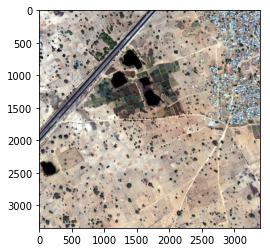

In [43]:
img_rgb = tiff.imread(str(data_dir / "three_band"/ f"{building_labels.index[7]}.tif")).transpose([1, 2, 0])
fig = plt.figure(figsize=(4,4))
tiff.imshow(255 * scale_percentile(img_rgb),figure=fig);

In [45]:
 img_rgb.shape

(3348, 3396, 3)

In [82]:
a = building_masks_train_dir.ls()
idx = np.random.choice(np.arange(len(a)), 9)

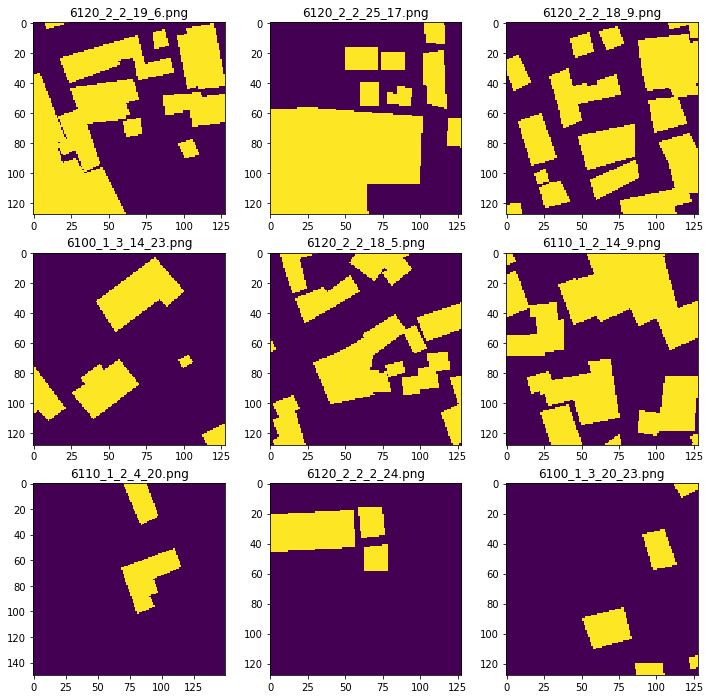

In [83]:
fig, axs = plt.subplots(3,3, figsize=(12,12))
nrows = 3
i = 0
for ax in axs.flat:
    ax.imshow(PIL.Image.open(a[i]))
    ax.set_title(a[i].name)
    i +=1

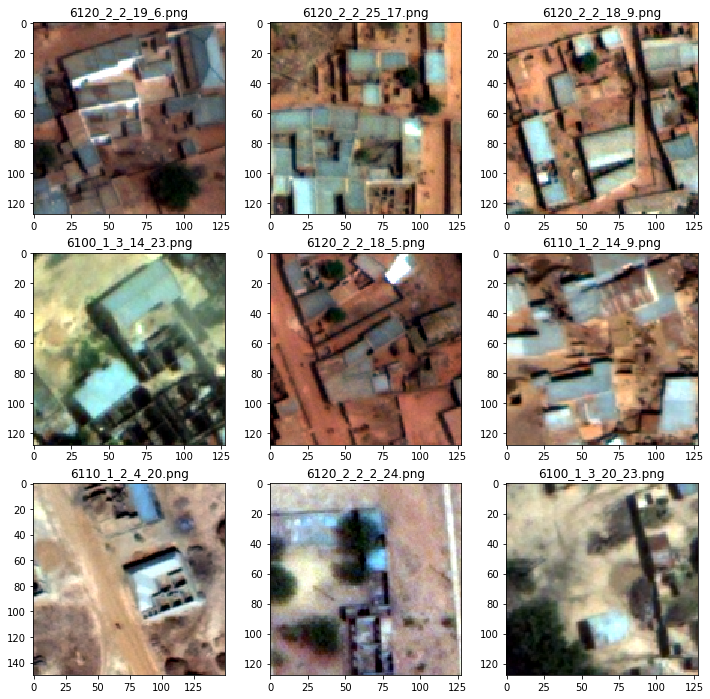

In [84]:
b = building_imgs_train_dir.ls()
fig, axs = plt.subplots(3,3, figsize=(12,12))
nrows = 3
i = 0
for ax in axs.flat:
    ax.imshow(PIL.Image.open(b[i]))
    ax.set_title(b[i].name)
    i +=1

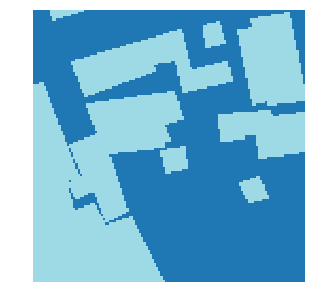

In [85]:
mask = open_mask(building_masks_train_dir /"6120_2_2_19_6.png")
mask.show(figsize=(5,5), alpha=1)

In [86]:
codes = np.array(["void", "building"])

In [87]:
class SegmentationLabelListCustom(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
class SegmentationItemListCustom(SegmentationItemList):
    "`ItemList` suitable for segmentation tasks."
    _label_cls,_square_show_res = SegmentationLabelListCustom,False

In [90]:
def get_mask_fn(fname):
    return building_masks_train_dir / fname
    
src = (SegmentationItemListCustom.from_folder(building_imgs_train_dir)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_mask_fn, classes=codes)
      )

In [92]:
batch_size = 8
size=128
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)
data = (src
        .transform(tfms, tfm_y=True, size=size)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

In [149]:
void_code =0
def pixel_accuracy(input, target):
#     print(target.max(), input.max())
#     print(target.shape, input.shape)
    target = target.squeeze(1)
    acc_mask = (target != 0)
    return (input.argmax(dim=1)[acc_mask] == target[acc_mask]).float().mean()

In [94]:
def jacquard(input, target):
    target = target.squeeze(1)
    acc_mask = (target != 0)
    threshold = 0.4
    predicted  = torch.where(input.argmax(dim=1) >= threshold, 1, 0)
    tp = (predicted== target).sum()
    fp = (predicted != target and predicted == 1).sum()
    fn = (predicted != target and predicted == 0).sum()
    return tp / (tp + fp + fn)

In [146]:
# metrics = [jacquard, pixel_accuracy]

In [95]:
wd = 1e-2
learn = unet_learner(data, models.resnet34, metrics=pixel_accuracy, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


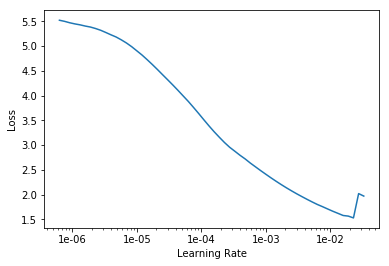

In [96]:
learn.lr_find()
learn.recorder.plot()

In [98]:
lr = 5e-02

In [99]:
# pct_start is Percentage of total number of epochs when learning rate rises during one cycle
# by default it is 0.3, but we might want a longer warmup
#https://forums.fast.ai/t/what-is-the-pct-start-mean/26168
# https://forums.fast.ai/t/how-to-choose-pct-start-in-onecyclescheduler/37391
learn.fit_one_cycle(4, slice(lr), pct_start=0.8)
# learn.fit_one_cycle(4, slice(lr), pct_start=0.5)

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.008381,0.009938,0.167300,00:25
1,0.006659,0.005442,0.717154,00:24
2,15.353957,0.009733,0.000000,00:24
3,0.019452,0.006075,0.733098,00:23


tensor(1, device='cuda:0') tensor(48.7870, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(47.5123, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(42.2291, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(43.8377, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(47.0906, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(41.3587, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(41.4868, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(41.2693, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(46.2687, device='cuda:

tensor(1, device='cuda:0') tensor(45.5777, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(45.9593, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(44.4055, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(44.7442, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(43.0050, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(45.8452, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(47.1305, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(44.5716, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(47.5971, device='cuda:

tensor(1, device='cuda:0') tensor(25.2012, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(25.0944, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(21.0904, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(21.1222, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(19.9097, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(21.6649, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(21.6589, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(21.6216, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(21.4333, device='cuda:

tensor(1, device='cuda:0') tensor(665.7809, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(665.8442, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(671.5276, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(673.2111, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(679.3456, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(665.8396, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(668.2540, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(672.5443, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(678.5928, devi

tensor(1, device='cuda:0') tensor(646.9284, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(638.6083, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(638.4223, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(639.7618, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(638.8760, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(639.7618, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(647.7016, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(643.7925, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(639.6248, devi

tensor(1, device='cuda:0') tensor(646.9056, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(639.4652, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(637.5223, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(639.6732, device='cuda:0')
torch.Size([8, 1, 128, 128]) torch.Size([8, 2, 128, 128])
tensor(1, device='cuda:0') tensor(638.3483, device='cuda:0')
torch.Size([1, 1, 128, 128]) torch.Size([1, 2, 128, 128])


In [100]:
learn.save("buildings-stage1")

In [43]:
print(learn.summary())

DynamicUnet
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 75, 75]         9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
ReLU                 [64, 75, 75]         0          False     
______________________________________________________________________
MaxPool2d            [64, 38, 38]         0          False     
______________________________________________________________________
Conv2d               [64, 38, 38]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 38, 38]         128        True      
______________________________________________________________________
ReLU                 [64, 38, 38]         0          False     
__________________________________________________

In [101]:
# this is in the form of a list of 2 lists, the predictions and the targets
train_predict = learn.get_preds(data.train_ds)

In [102]:
predictions = train_predict[0]
targets = train_predict[1]

In [121]:
outputs = predictions[1]
predictions2= predictions[:, 1, :, :] 

In [122]:
predictions2[predictions2 > 0.1] = 1.
predictions2[predictions2<= 0.1] = 0.
predictions2.shape

torch.Size([2823, 128, 128])

In [114]:
learn.data.train_dl.items

array([PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6120_2_2_25_17.png'),
       PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6120_2_2_18_9.png'),
       PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6100_1_3_14_23.png'),
       PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6120_2_2_18_5.png'), ...,
       PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6100_1_3_3_14.png'),
       PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6070_2_3_17_20.png'),
       PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6140_1_2_2_8.png'),
       PosixPath('/media/wwymak/Storage/kaggle-dstl/building_imgs_train/6110_1_2_5_17.png')], dtype=object)

In [123]:
a =predictions2[0].numpy()
a

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.]], dtype=float32)

In [127]:
a.sum()

32.0

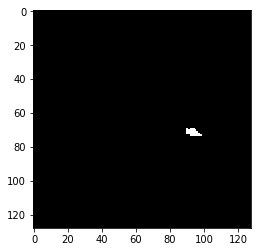

In [126]:
    
fig = plt.figure(figsize=(4,4))
show_mask(a.astype(np.uint8),figure=fig)

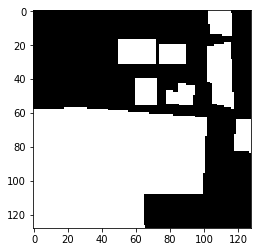

In [117]:
b = PIL.Image.open(building_masks_train_dir /"6120_2_2_25_17.png")
show_mask(np.array(b).astype(np.uint8),figure=fig)

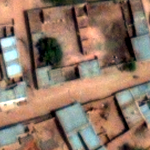

In [163]:
PIL.Image.open(building_imgs_train_dir/"6120_2_2_19_6.png")

In [185]:

pixel_accuracy(a.unsqueeze(0), pil2tensor(b,dtype=np.int8).unsqueeze(0))

torch.Size([1, 1, 150, 150]) torch.Size([1, 1, 150, 150])


RuntimeError: Expected object of scalar type Long but got scalar type Char for argument #2 'other'

In [186]:
target = pil2tensor(b,dtype=np.int8).unsqueeze(0)
target.squeeze(1)
acc_mask = 

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]], dtype=torch.int8)

#### Sanity check -- predict mask from mask

In [159]:
(data_dir/"dummy_img_dir").mkdir(exist_ok=True)
dummy_img_dir = (data_dir/"dummy_img_dir")

In [160]:
def save_dummy(fname):
    m = np.array(PIL.Image.open(building_masks_train_dir / fname))
#     print(m.shape)
    arr = (255 * np.stack([m, m, m])).astype(np.uint8)
    arr = np.moveaxis(arr, 0, -1)
#     print(arr.shape)
    im = PIL.Image.fromarray(arr)
    im.save(dummy_img_dir/ f"{fname}" )

[save_dummy(f) for f in os.listdir(building_masks_train_dir) if f.endswith(".png")]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [161]:

src = (SegmentationItemListCustom.from_folder(dummy_img_dir)
       .split_by_rand_pct(0.2, seed=42)
       .label_from_func(get_mask_fn, classes=codes)
      )

In [163]:
batch_size = 8
size=128
tfms = get_transforms(flip_vert=True,  max_zoom=1.05, max_warp=0.)
data = (src
        .transform(tfms, tfm_y=True, size=size)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

In [164]:
wd = 1e-2
learn = unet_learner(data, models.resnet34, metrics=pixel_accuracy, wd=wd, bottle=True)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


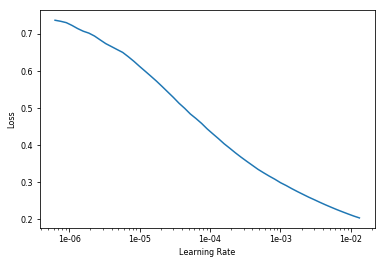

In [165]:
learn.lr_find()
learn.recorder.plot()

In [166]:
lr = 0.5e-2
learn.fit_one_cycle(4, slice(lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.004990,0.000387,0.999541,00:23
1,0.003636,0.000249,0.999624,00:23
2,0.003691,0.000230,0.999585,00:24
3,0.003338,0.000206,0.999727,00:24


In [188]:
oreds, targets = learn.get_preds()

/home/wwymak/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


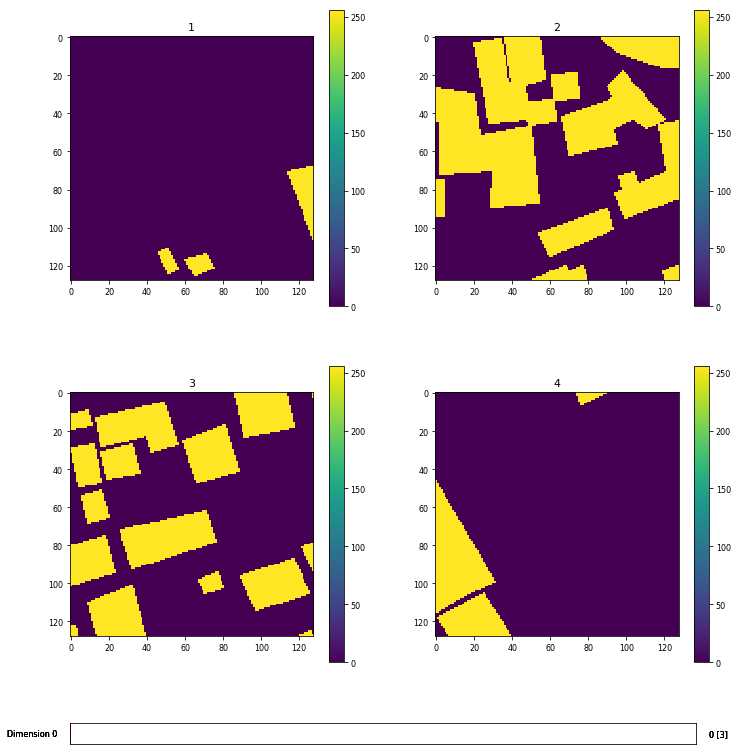

In [189]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

show_mask(targets[0].numpy(), figure=fig, subplot=ax1, title=1)
show_mask(targets[1].numpy(), figure=fig, subplot=ax2, title=2)
show_mask(targets[2].numpy(), figure=fig, subplot=ax3, title=3)
show_mask(targets[3].numpy(), figure=fig, subplot=ax4, title=4)

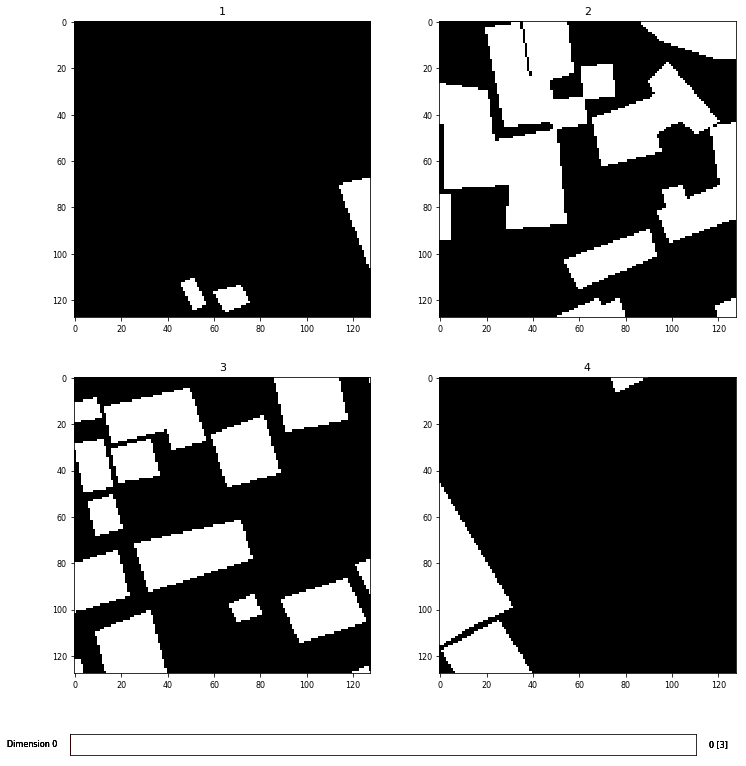

In [173]:
def actual_mask(idx):
    arr = np.array(PIL.Image.open(learn.data.valid_dl.items[idx]))
    return 255*arr.astype(np.uint8)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))

show_mask(actual_mask(0), figure=fig, subplot=ax1, title=1)
show_mask(actual_mask(1), figure=fig, subplot=ax2, title=2)
show_mask(actual_mask(2), figure=fig, subplot=ax3, title=3)
show_mask(actual_mask(3), figure=fig, subplot=ax4, title=4)

#### Sanity check 2
Now that we know we can accurately create masks from clean masks images, let's check that the process for generating wkt polygons is accurate

In [ ]:
def mask_to_polygons(mask, epsilon=10.,):
    # see https://docs.opencv.org/trunk/d9/d8b/tutorial_py_contours_hierarchy.html
    image, contours, hierarchy = cv2.findContours(
        (mask * 255).astype(np.uint8),
#         ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True) for cnt in contours]

In [190]:
cv2.findContours??